## Imports

In [1]:
import pandas as pd
import numpy as np
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style='darkgrid')

import xgboost as xgb
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge,Lasso, ElasticNet

from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneOut
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
data = pd.read_csv("Data/processed_real_estate_data.csv")
data.shape

(195, 9)

In [3]:
data.describe().T

# sa: Sub_area
# sa1: baner, sa9: nibm, sa7: kharadi, sa2: bavdhan, sa5: handewadi

,count,mean,std,min,25%,50%,75%,max
property_area_SqFt,195.0,1.275333e-16,1.002574,-1.659986,-0.611273,-0.272458,0.39576,4.167092
n_bhk,195.0,2.379487e+00,0.846210,1.000000,2.000000,2.000000,3.00000,6.000000
sa1,195.0,6.153846e-02,0.240934,0.000000,0.000000,0.000000,0.00000,1.000000
pool,195.0,6.307692e-01,0.483839,0.000000,0.000000,1.000000,1.00000,1.000000
sa9,195.0,4.102564e-02,0.198860,0.000000,0.000000,0.000000,0.00000,1.000000
sa7,195.0,8.205128e-02,0.275149,0.000000,0.000000,0.000000,0.00000,1.000000
sa2,195.0,5.128205e-02,0.221140,0.000000,0.000000,0.000000,0.00000,1.000000
sa5,195.0,5.641026e-02,0.231306,0.000000,0.000000,0.000000,0.00000,1.000000
price,195.0,8.669949e+00,5.808464,1.319000,5.100000,7.000000,9.70000,46.000000


## Data Prepration

In [4]:
# doing this for plotting purposes
data = data.sort_values("property_area_SqFt").reset_index(drop=True)

In [5]:
# Selecting the feature matrix and target vector
X = data.iloc[:, :-1]
y = data["price"]

In [6]:
# Random sate for data splitting
rs = 118
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.3, random_state=rs) 

In [7]:
# function for performing grid search
def gridSearchReport(estimator, X, y, pg, cv=LeaveOneOut(), rs=118):
    """
    Performs the grid search and cross validation for the given regressor.
    Params:
        estimator:  the regressor
        X: Pandas dataframe, feature data
        y: Pandas series, target
        pg: dict, parameters' grid
        cv: int, cross-validation generator or an iterable, cross validation folds
        rs: int, training-test split random state
    """    

    t0 = time()
    
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.3, random_state=rs) # train tets split
    
    est_cv = GridSearchCV(
        estimator, 
        param_grid=pg, 
        scoring="neg_mean_squared_error", 
        n_jobs=-1, 
        cv=cv
       )
    
    est_cv.fit(X_train, y_train)
    
    print("Best parameters:", est_cv.best_params_) # best parameters
    
    print("Best CV score:", abs(est_cv.best_score_)) # cross validation score
    
    y_train_pred, y_test_pred = est_cv.predict(X_train), est_cv.predict(X_test) # predictions on train and test data
    
    print("MSE, R2 train:", mean_squared_error(y_train, y_train_pred),  # evaluation metrics
          ", ", r2_score(y_train, y_train_pred) )
    
    print("MSE, R2 test:", mean_squared_error(y_test, y_test_pred),
          ", ", r2_score(y_test, y_test_pred) )
    
    t = round(time()-t0, 2)
    
    print("Elapsed time:", t, "s ,", round(t/60, 2), "min")
    
    return est_cv

In [8]:
# function to plot the residuals
def plotResidue(estimator, X, y, rs=118):
    """
    Plots the fit residuals (price - predicted_price) vs. "property_area_SqFt" variable.
    Params:
        estimator: GridSearchCV, the regressor
        X: Pandas dataframe, feature data
        y: Pandas series, target
        rs: int, random state
    """    
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.3, random_state=rs) # train tets split

    residue_train = y_train-estimator.predict(X_train) # make predictions
    residue_test = y_test-estimator.predict(X_test)                                                     
                                                          
    fig, axe = plt.subplots(1, 2, figsize=(18,10)) 
    axe[0].scatter(X_train["property_area_SqFt"], residue_train, label="train")
    axe[0].scatter(X_test["property_area_SqFt"], residue_test, label="test")
    axe[0].plot([-2.3, 4.5], [0,0], "black")
    axe[0].set_xlabel("Scaled property_area_SqFt")
    axe[0].set_ylabel("Fit residulas")
    axe[0].legend()
    
    axe[1].hist(residue_test, bins=25)
    axe[1].set_xlabel("Fit residual for test set")
    axe[1].set_ylabel("Count")


    plt.show()

    print("mean residuals:", round(np.mean(residue_test), 2),
          "\nstd:", round(np.std(residue_test), 2))

## Linear Regression

In [9]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [10]:
r2_score(y_train, lr.predict(X_train)), \
r2_score(y_test, lr.predict(X_test))

(0.8529531248715025, 0.7181368755446089)

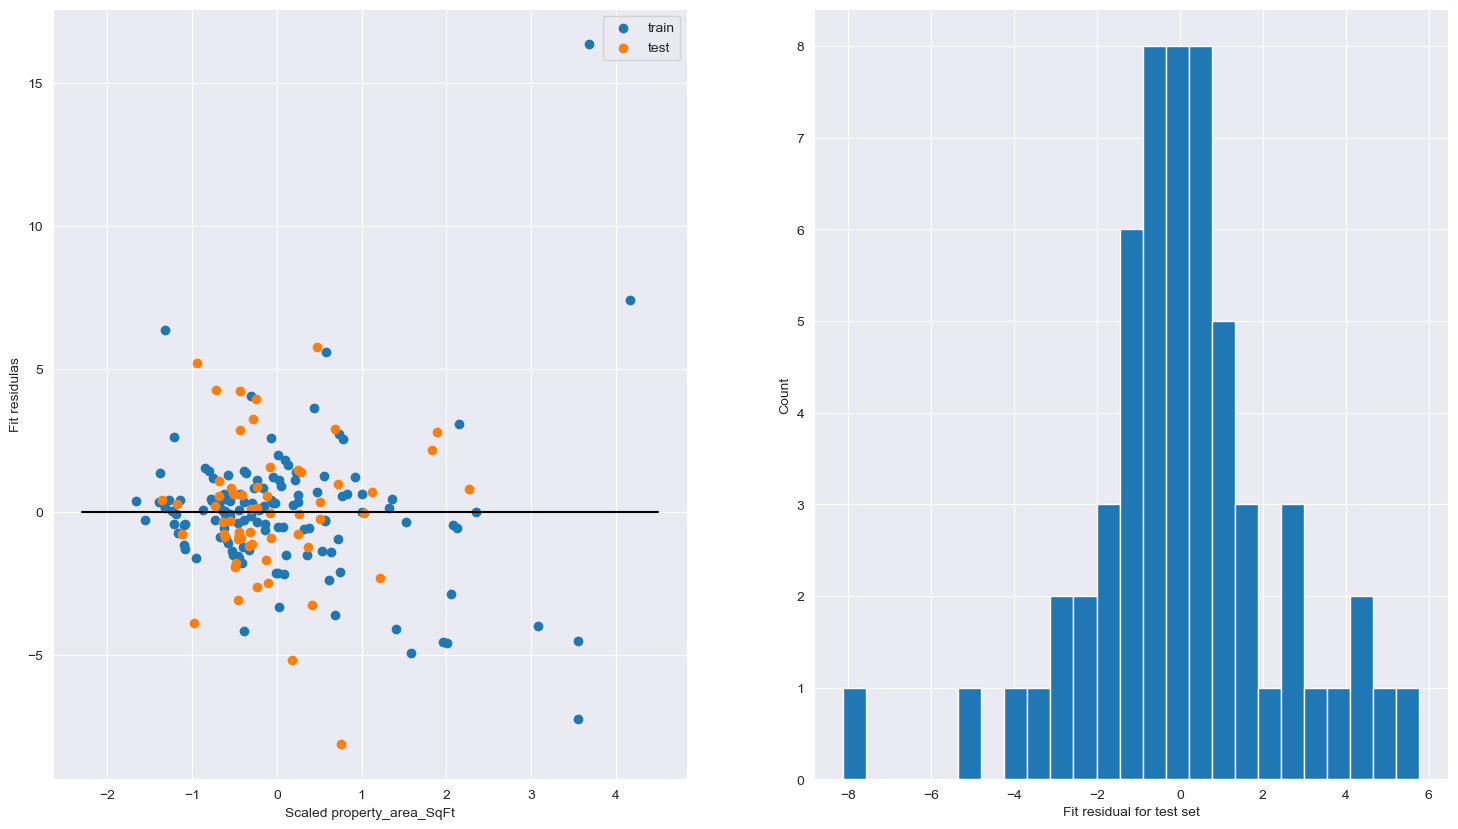

mean residuals: 0.03 
std: 2.37


In [11]:
# plot the residuals
plotResidue(lr, X, y, rs=rs)

## Ridge Regression

In [12]:
# define the parameters for ridge regression model and check for the grid search 
alphas = np.logspace(-3,3,100)
pg = {"alpha":alphas}
ridge = Ridge()
ridg_cv = gridSearchReport(ridge, X, y, pg, rs=rs)

Best parameters: {'alpha': 1.072267222010323}
Best CV score: 7.551967673176315
MSE, R2 train: 5.835764217614137 ,  0.8519436476898729
MSE, R2 test: 5.268560992571397 ,  0.7363307265262057
Elapsed time: 8.2 s , 0.14 min


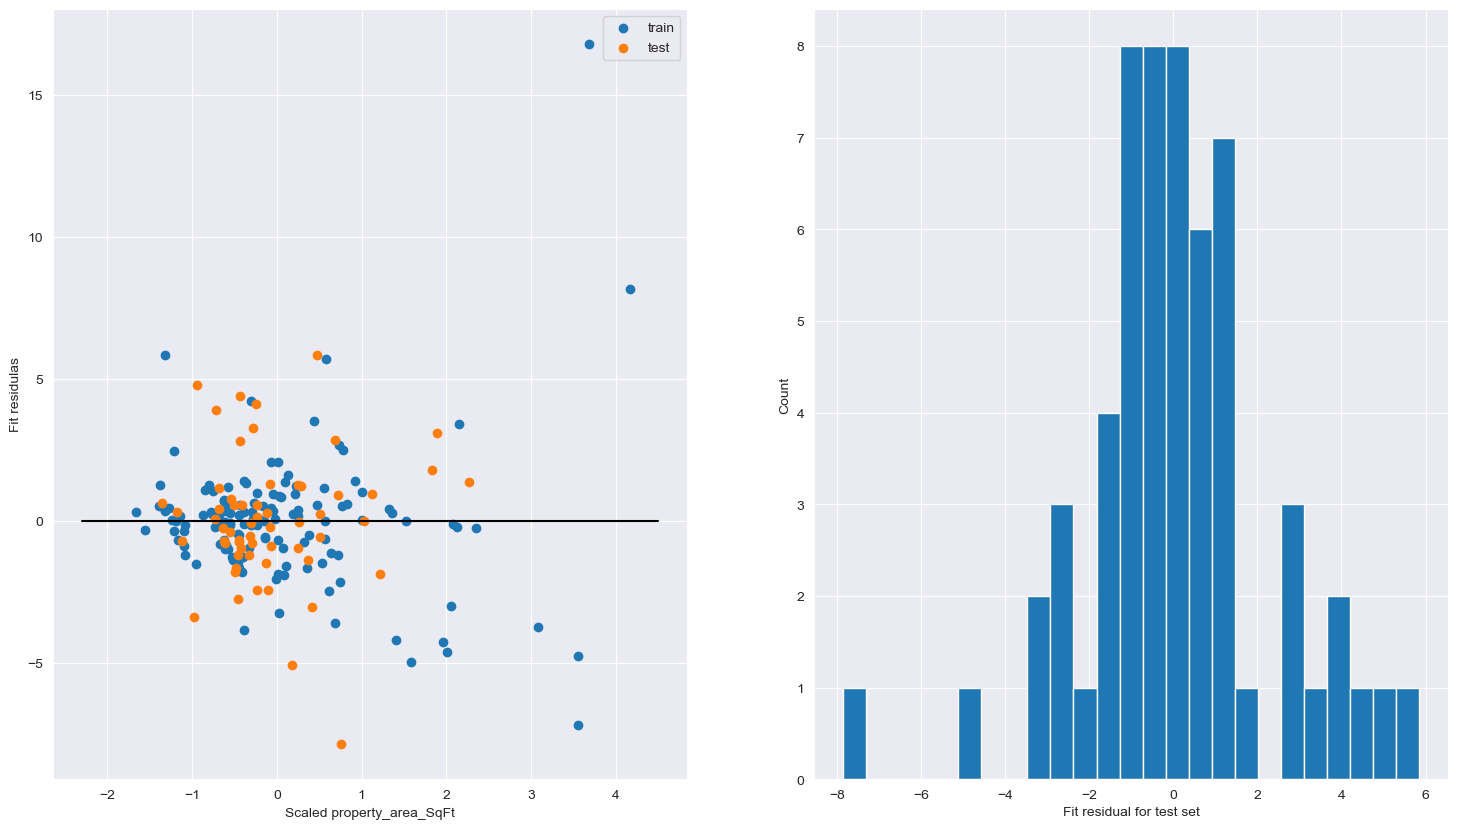

mean residuals: 0.05 
std: 2.29


In [13]:
# plot the residuals
plotResidue(ridg_cv, X, y, rs)

## Lasso Regression

In [14]:
# define the parameters and plot the lasso regression model
lasso = Lasso()
pg = {"alpha":alphas}
lasso_cv = gridSearchReport(lasso, X, y, pg, rs=rs)

Best parameters: {'alpha': 0.001}
Best CV score: 7.609724286205723
MSE, R2 train: 5.796124032267342 ,  0.8529493396658491
MSE, R2 test: 5.6137247095075535 ,  0.7190567371764777
Elapsed time: 4.83 s , 0.08 min


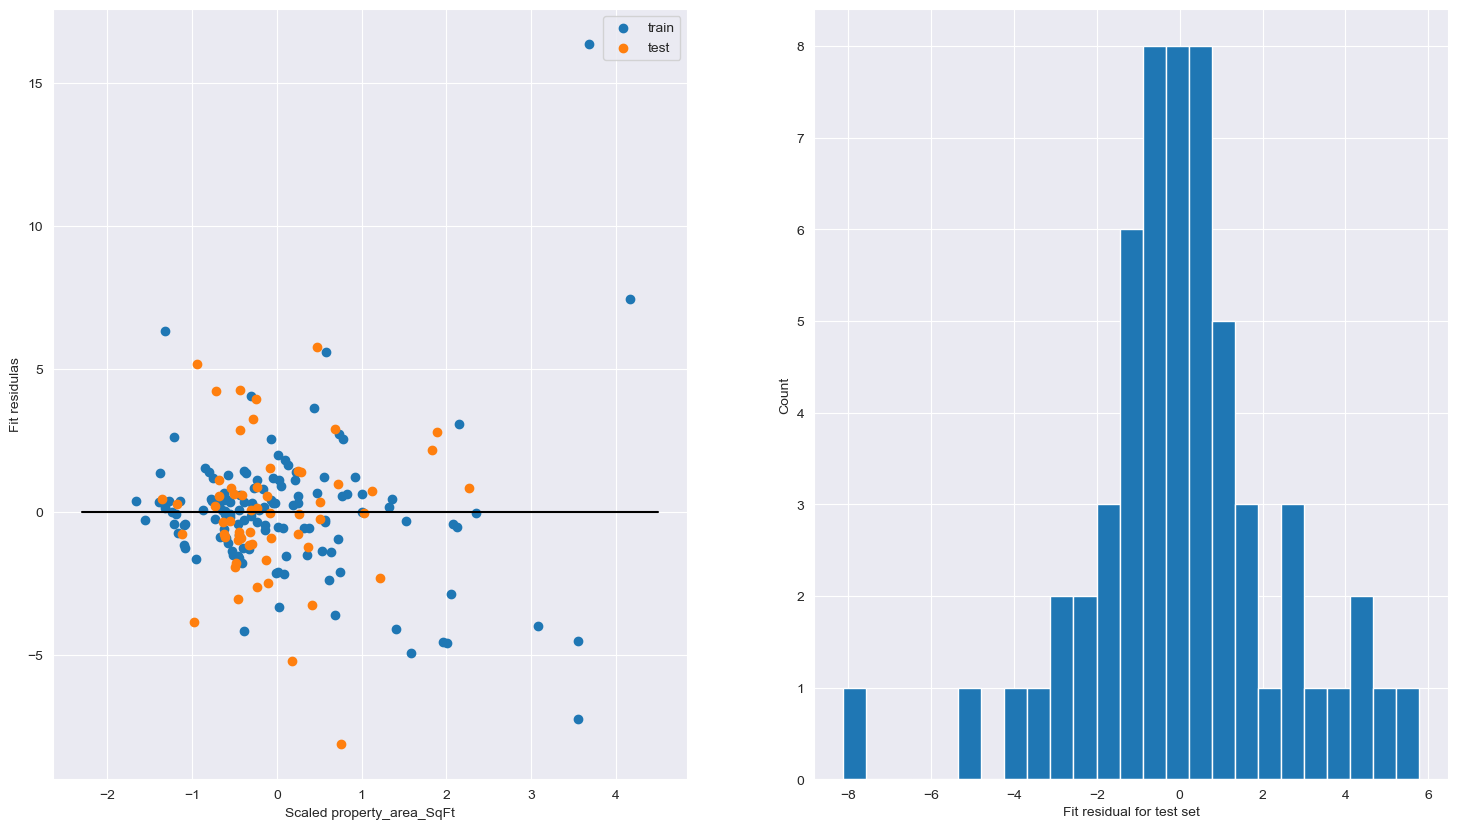

mean residuals: 0.03 
std: 2.37


In [15]:
# plot the residuals 
plotResidue(lasso_cv, X, y, rs=rs)

## Lasso and Ridge Combination

In [16]:
# define an elasticnet model 
l1_ratio = np.random.rand(20)
elastic = ElasticNet()
pg = {"alpha":np.linspace(0.1,1,5), "l1_ratio":l1_ratio}
elastic_cv = gridSearchReport( elastic, X, y, pg, rs=rs )

Best parameters: {'alpha': 0.1, 'l1_ratio': 0.9979859332601047}
Best CV score: 8.1840459570918
MSE, R2 train: 6.397388924283558 ,  0.8376949388085679
MSE, R2 test: 4.837949537116428 ,  0.7578810150716726
Elapsed time: 5.84 s , 0.1 min


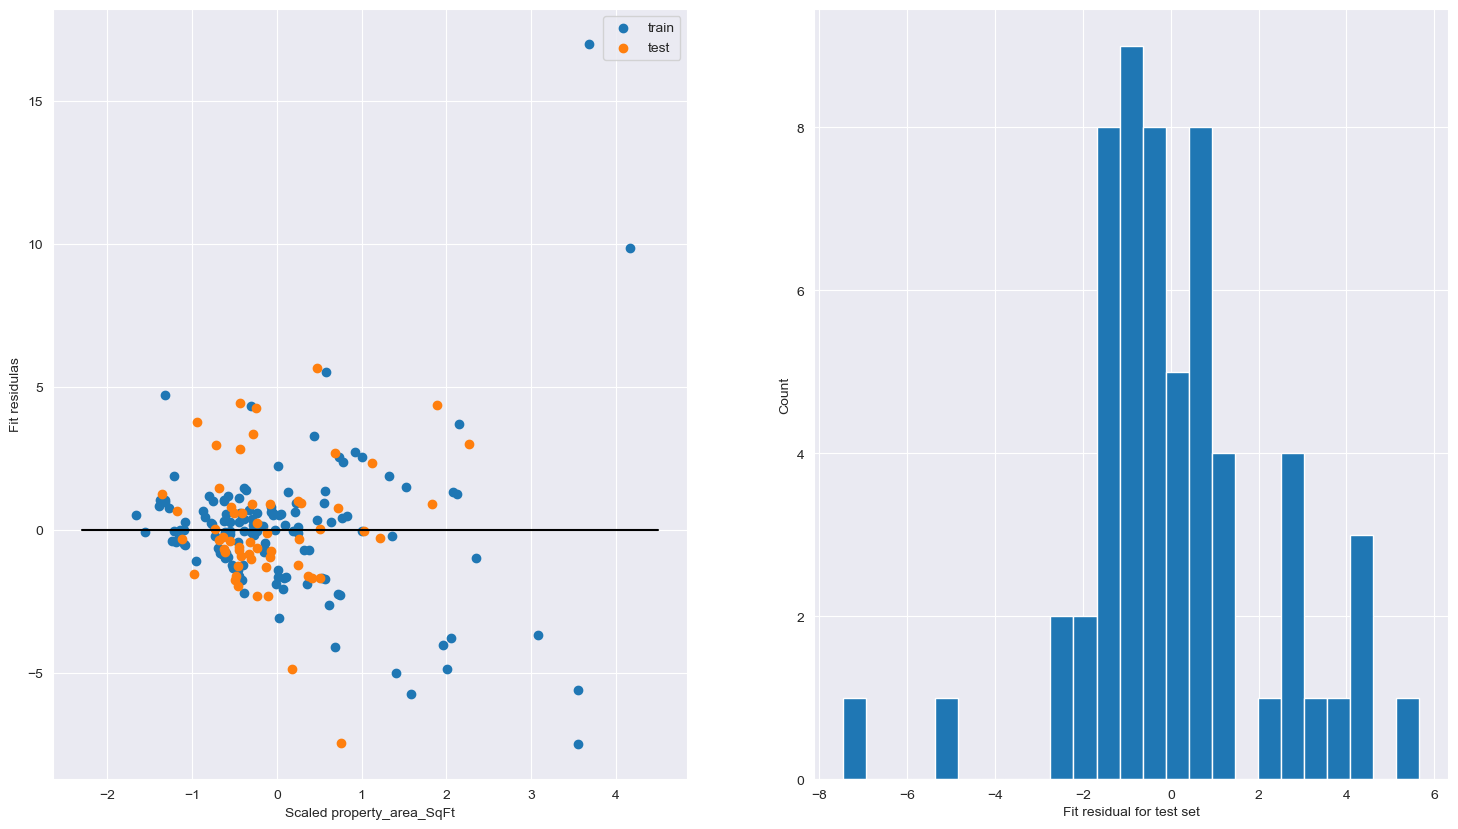

mean residuals: 0.13 
std: 2.2


In [17]:
# plot the residuals
plotResidue(elastic_cv, X, y, rs=rs)

## Random Forest Regressor

In [18]:
# define a random forest regression model 
rfr = RandomForestRegressor(random_state=10)

pg = {"n_estimators":[10, 20, 30, 50],
      "criterion":["squared_error", "absolute_error", "poisson"],
      "max_depth":[2,3,4],
      "min_samples_split":range(2, 10),
      "min_samples_leaf":[2,3],
      "max_features":range(4, X_train.shape[1]+1)}

rfr_cv = gridSearchReport( rfr, X, y, pg, cv=5, rs=rs )

Best parameters: {'criterion': 'poisson', 'max_depth': 4, 'max_features': 8, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Best CV score: 9.087202880433571
MSE, R2 train: 3.2976908072390425 ,  0.9163358809986223
MSE, R2 test: 4.520994177856064 ,  0.7737432950030694
Elapsed time: 54.35 s , 0.91 min


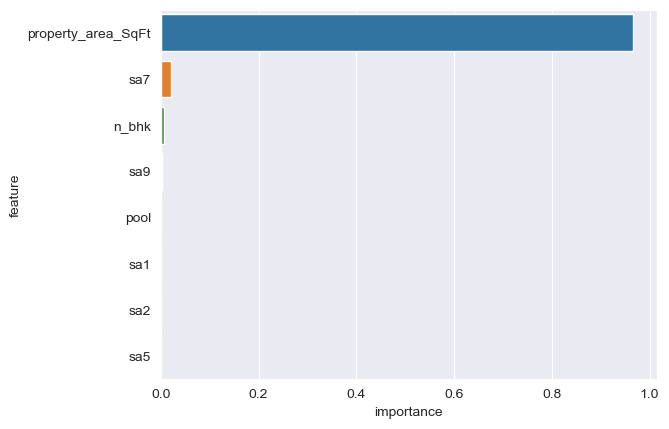

In [19]:
# find the best features 
rfr = rfr_cv.best_estimator_

df_imp = pd.DataFrame(zip(rfr.feature_names_in_, rfr.feature_importances_))

df_imp.columns = ["feature", "importance"]

df_imp = df_imp.sort_values("importance", ascending=False).reset_index(drop=True)

sns.barplot( data=df_imp, x="importance", y="feature"  )
plt.show();

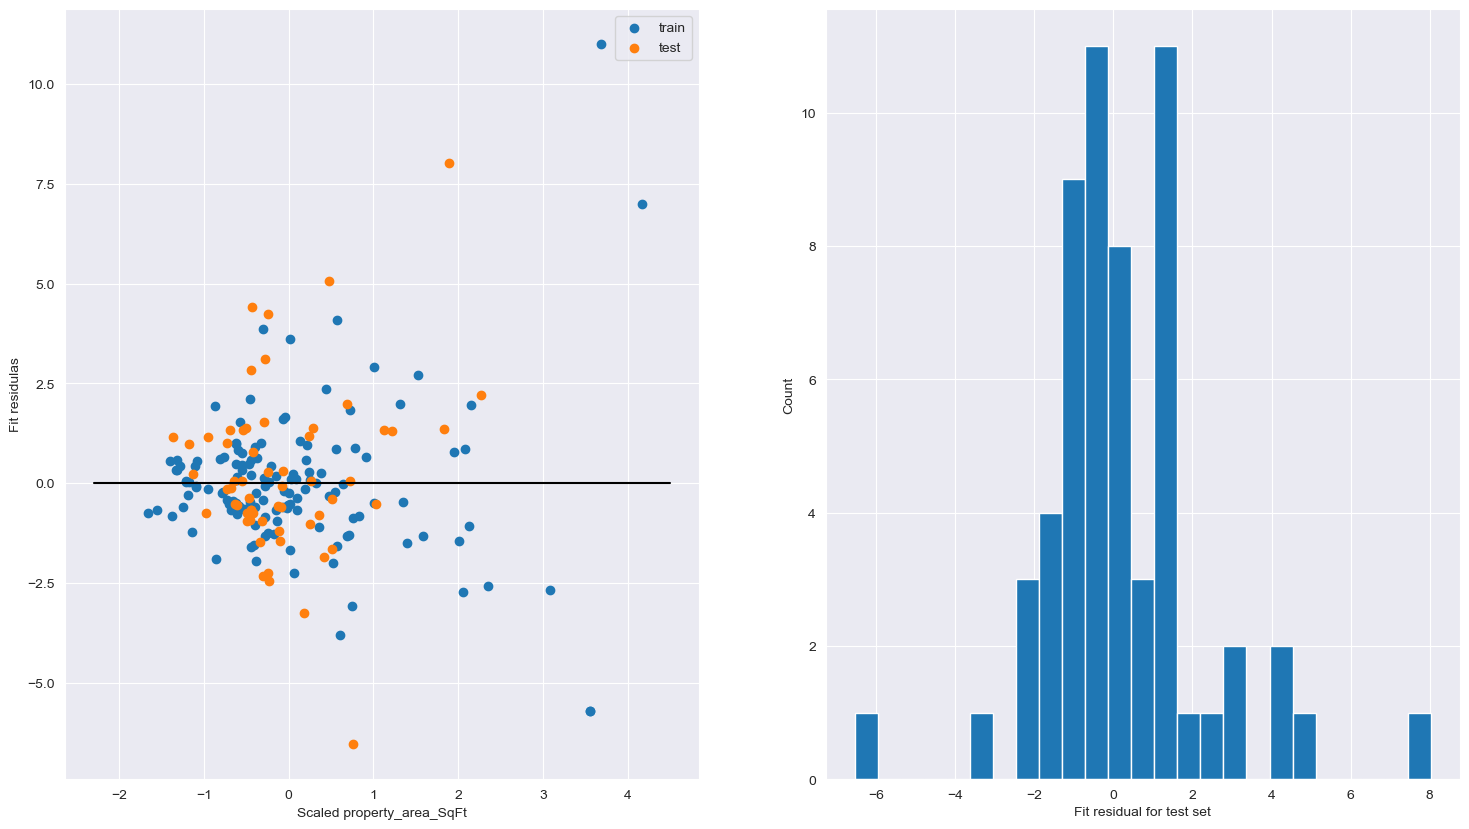

mean residuals: 0.23 
std: 2.11


In [21]:
# plot the residuals
plotResidue(rfr_cv, X, y, rs=rs)

## XGboost (extreme gradient boosting)

In [22]:
# define the parameters for XGBoost model

from scipy.stats import uniform

param_grid = {'max_depth':range(2,7),
              'gamma':uniform(loc=0.0, scale=3), # minimum of the loss function reduction to split a node
              'min_child_weight':range(3,6), # similar to min_samples_leaf
              'colsample_bytree':uniform(loc=0.1, scale=0.9), # similar to the max_features
              'subsample':uniform(loc=0.5, scale=0.5), # similar to bootstraping in RF
              'learning_rate':uniform(loc=0.01, scale=0.99)} # contriburion rate of each estimator

In [26]:
from sklearn.model_selection import ParameterSampler

rng = np.random.RandomState(20)

n_iter=500
param_list = list(ParameterSampler(param_grid, n_iter=n_iter,
                                   random_state=rng))

param_list[0]

{'colsample_bytree': 0.6293177209695467,
 'gamma': 2.6931411837282537,
 'learning_rate': 0.8926154221799609,
 'max_depth': 3,
 'min_child_weight': 3,
 'subsample': 0.5179447928084266}

In [32]:
# function to perform cross validation
from sklearn.model_selection import KFold

def cross_validate(est, Xn, yn, n_fold=10):
    """
    Cross validation for XGB fit.
    Params:
        est: xgb regressor
        Xn: numpy array (n_sample, n_feature)
            Training feature matrix
        yn: numpy array (n_sample,)
            Training target vector
        n_fold: int
            number of folds for cross validating
    """
    kf = KFold(n_splits=n_fold, shuffle=True, random_state=0)
    mean_train_error, mean_val_error = 0., 0.
    for train_index, val_index in kf.split(Xn, yn):
        
        est.fit(Xn[train_index], yn[train_index], 
                eval_set=[(Xn[train_index], yn[train_index]), 
                          (Xn[val_index], yn[val_index])],
                verbose=False)
        
        mean_val_error += mean_squared_error(yn[val_index], est.predict(Xn[val_index]))
        mean_train_error += mean_squared_error(yn[train_index], est.predict(Xn[train_index]))

    return mean_train_error/n_fold, mean_val_error/n_fold

In [33]:
%%time

# XGBoost model
xgbr = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000,eval_metric='rmse',early_stopping_rounds=30, verbosity=1) 

val_score, train_score = [], []
counter = 0
for param_grid in param_list:
    xgbr.set_params(**param_grid)
    train_error, val_error = cross_validate(xgbr, X_train.values, y_train.values)  
    val_score.append(val_error)
    train_score.append(train_error)
    
    if counter%50 == 0 :
        print("iter =", counter, 
              "train_score=", train_score[counter], ", ", 
              "val_score=", val_score[counter])
    counter += 1
        

iter = 0 train_score= 8.940012643658815 ,  val_score= 10.894566318491893
iter = 50 train_score= 6.789004453699128 ,  val_score= 8.501862874086791
iter = 100 train_score= 6.827841316268765 ,  val_score= 9.349167633018862
iter = 150 train_score= 7.760246769727118 ,  val_score= 11.113006959399819
iter = 200 train_score= 10.050703877323205 ,  val_score= 10.687912542521484
iter = 250 train_score= 5.511139242417498 ,  val_score= 8.145587960786886
iter = 300 train_score= 7.229877997602117 ,  val_score= 10.487532117464193
iter = 350 train_score= 8.05726261756572 ,  val_score= 8.680673468010298
iter = 400 train_score= 12.208998296070652 ,  val_score= 11.245957213325877
iter = 450 train_score= 8.611353346028546 ,  val_score= 11.19426931532949
CPU times: total: 19min 59s
Wall time: 2min 6s


In [34]:
df_grid = pd.DataFrame(param_list)
df_grid["train_score"] = train_score
df_grid["val_score"] = val_score
df_grid

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,subsample,train_score,val_score
0,0.629318,2.693141,0.892615,3,3,0.517945,8.940013,10.894566
1,0.722582,1.136043,0.523326,4,5,0.596925,9.772273,10.495970
2,0.345085,2.155818,0.785174,3,4,0.887622,12.589474,12.347395
3,0.132998,0.350081,0.753768,4,4,0.627403,14.828658,10.783183
4,0.871863,2.849337,0.566070,2,5,0.726722,8.965160,10.247189
...,...,...,...,...,...,...,...,...
495,0.287347,1.044718,0.207315,5,4,0.521568,14.387778,10.595192
496,0.211245,2.442034,0.178679,4,3,0.501152,14.946191,12.339310
497,0.772129,2.011557,0.063765,5,3,0.881116,5.579841,8.997020
498,0.206156,1.858437,0.288957,2,3,0.929107,13.158959,12.312985


In [35]:
df_grid_best = df_grid[ df_grid["val_score"]==min(val_score) ]
df_grid_best

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,subsample,train_score,val_score
311,0.40847,0.336532,0.988843,2,4,0.511955,7.972533,6.686067


In [36]:
# best parameters
best_params = df_grid_best.iloc[0, :-2].to_dict()
best_params

{'colsample_bytree': 0.4084697952340547,
 'gamma': 0.33653217506954924,
 'learning_rate': 0.9888430226222338,
 'max_depth': 2.0,
 'min_child_weight': 4.0,
 'subsample': 0.511955315318599}

In [37]:
best_params["max_depth"] = int(best_params["max_depth"])

In [39]:
xgbr.set_params(**best_params)
xgbr.fit(X_train, y_train, 
                eval_set=[(X_train, y_train), (X_test, y_test)],
                verbose=True)

[0]	validation_0-rmse:6.03216	validation_1-rmse:4.24606
[1]	validation_0-rmse:6.06463	validation_1-rmse:4.26825
[2]	validation_0-rmse:4.30757	validation_1-rmse:2.98944
[3]	validation_0-rmse:4.13587	validation_1-rmse:3.01929
[4]	validation_0-rmse:4.07617	validation_1-rmse:2.84183
[5]	validation_0-rmse:4.04959	validation_1-rmse:2.75089
[6]	validation_0-rmse:3.78084	validation_1-rmse:2.62814
[7]	validation_0-rmse:3.70284	validation_1-rmse:2.45286
[8]	validation_0-rmse:3.54033	validation_1-rmse:2.59894
[9]	validation_0-rmse:3.48782	validation_1-rmse:2.76536
[10]	validation_0-rmse:3.71083	validation_1-rmse:2.43172
[11]	validation_0-rmse:3.68187	validation_1-rmse:2.50986
[12]	validation_0-rmse:3.59461	validation_1-rmse:2.59420
[13]	validation_0-rmse:3.58971	validation_1-rmse:2.64103
[14]	validation_0-rmse:3.60191	validation_1-rmse:2.73624
[15]	validation_0-rmse:3.29026	validation_1-rmse:2.62361
[16]	validation_0-rmse:3.26231	validation_1-rmse:2.63838
[17]	validation_0-rmse:2.99061	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.4084697952340547, early_stopping_rounds=30,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=0.33653217506954924, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.9888430226222338, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=4.0, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [40]:
xgbr.get_booster().attributes()

{'best_iteration': '10',
 'best_ntree_limit': '11',
 'best_score': '2.431717878072276'}

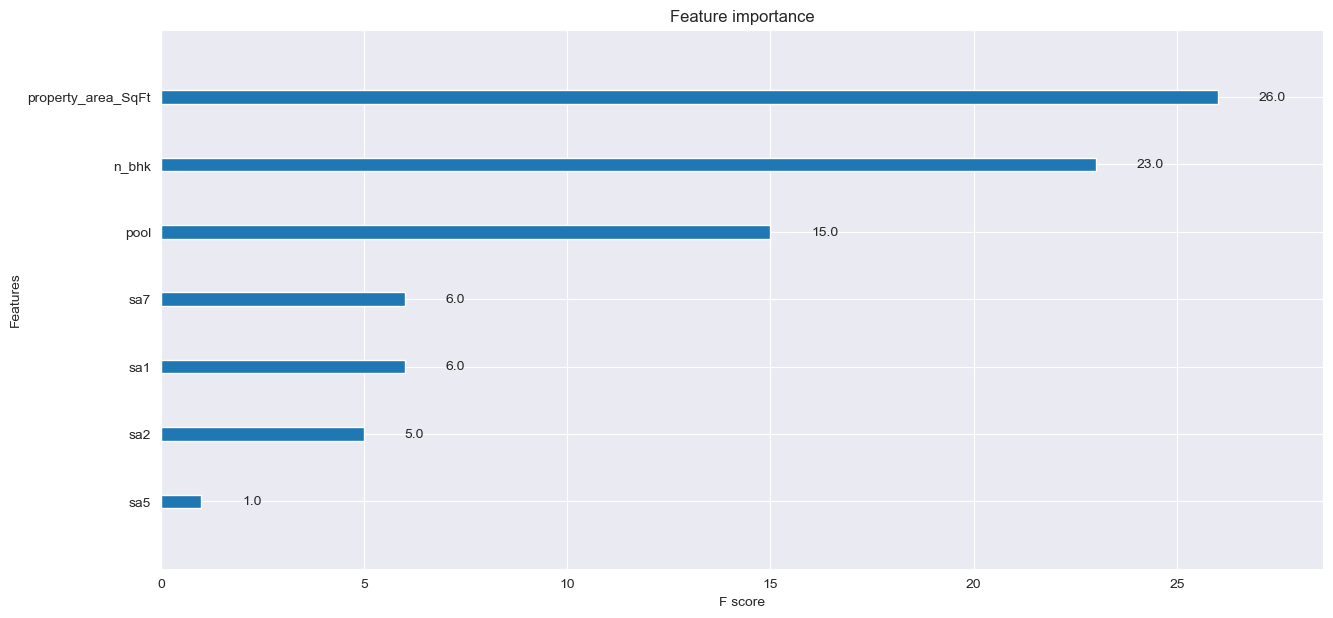

In [41]:
# plot the feature importance 
plt.rcParams["figure.figsize"] = (15,7)
xgb.plot_importance(xgbr)
plt.show();

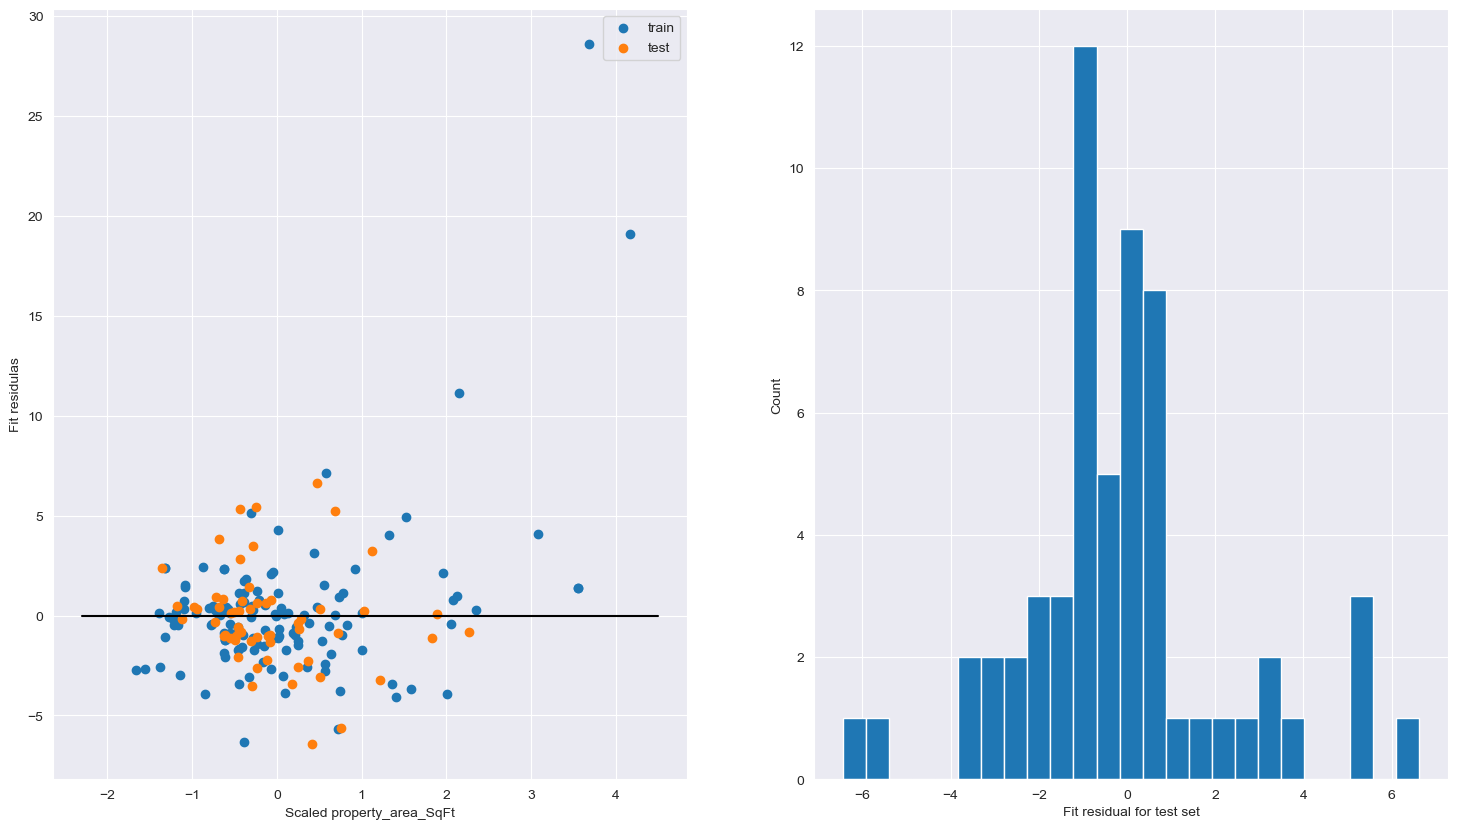

mean residuals: -0.12 
std: 2.43


In [42]:
#  plot the residuals
plotResidue(xgbr, X, y, rs=rs)

## K-Nearest Neighbours Regression

In [43]:
%%time
knn = KNeighborsRegressor() # KNN model

pg = {
    "n_neighbors": range(1,16),
    "weights": ['uniform', 'distance'],
    "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute']
}

knn_cv = gridSearchReport(knn, X, y, pg, rs=rs)

Best parameters: {'algorithm': 'brute', 'n_neighbors': 3, 'weights': 'uniform'}
Best CV score: 8.41911496486928
MSE, R2 train: 5.027453534313725 ,  0.8724509072089514
MSE, R2 test: 4.9078104086628995 ,  0.7543847728774802
Elapsed time: 40.54 s , 0.68 min
CPU times: total: 13 s
Wall time: 40.5 s


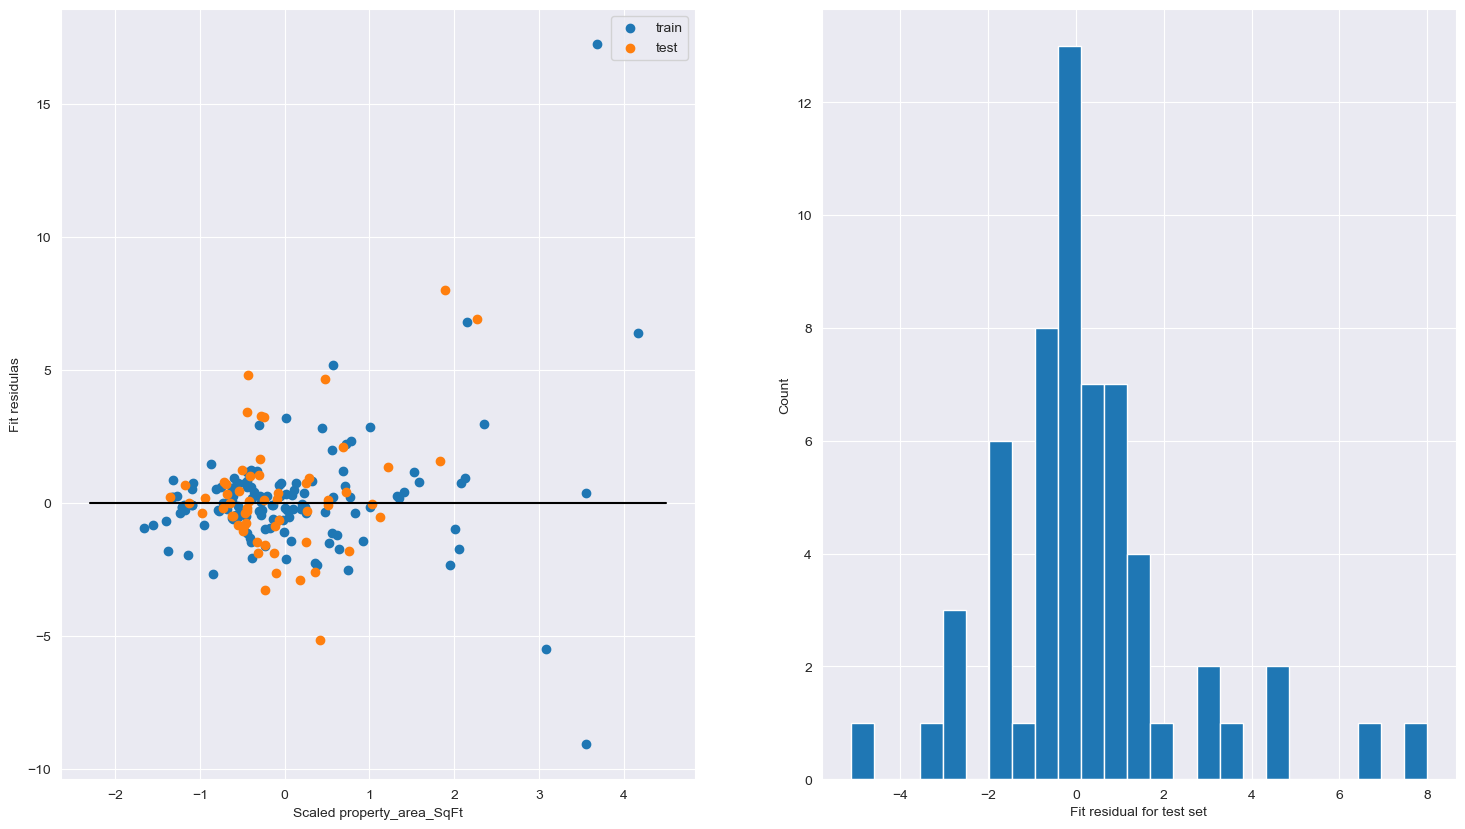

mean residuals: 0.27 
std: 2.2


In [44]:
# plot the residuals
plotResidue(knn_cv, X, y, rs=rs)

In [45]:
from sklearn.model_selection import validation_curve
param_range = range(1,31)
knn_cv = KNeighborsRegressor()
train_scores, val_scores = validation_curve(knn_cv, 
                                            X_train, y_train, 
                                            param_name="n_neighbors",
                                            param_range=param_range,
                                            n_jobs=-1,
                                            scoring="neg_mean_squared_error", 
                                            cv=10)

In [46]:
train_scores.shape

(30, 10)

In [47]:
train_mean_score = -np.mean(train_scores, axis=1)
val_mean_score = -np.mean(val_scores, axis=1)

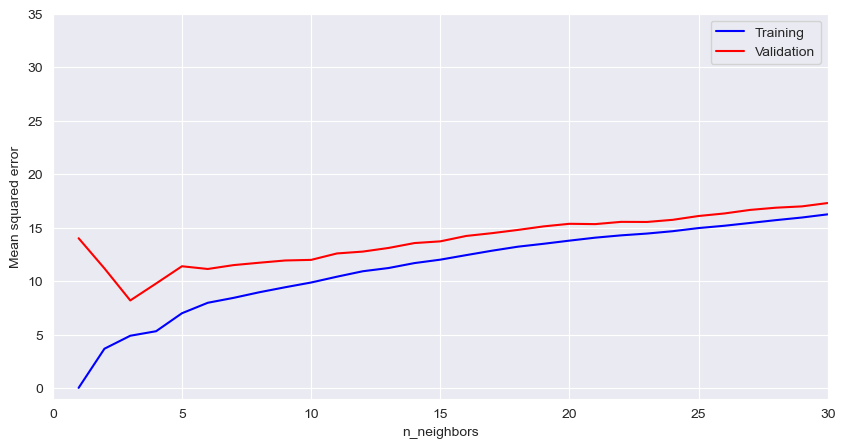

In [48]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot( param_range, train_mean_score, color="b", label="Training" )
plt.plot( param_range, val_mean_score, color="r", label="Validation" )
plt.xlim(1,15)
plt.xlabel( "n_neighbors" )
plt.ylim(-1, 35)
plt.xlim(0, 30)
plt.ylabel( "Mean squared error" )
plt.legend()
plt.show();

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


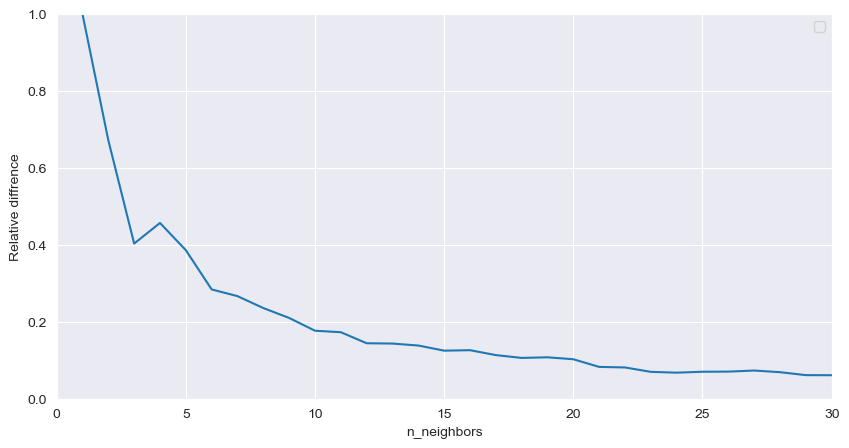

In [49]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot( param_range, (val_mean_score-train_mean_score)/val_mean_score )
plt.xlim(1,15)
plt.xlabel( "n_neighbors" )
plt.ylim(0, 1)
plt.xlim(0, 30)
plt.ylabel( "Relative diffrence" )
plt.legend()
plt.show();

In [50]:
knn_cv = KNeighborsRegressor(n_neighbors=20, weights="uniform")
knn_cv.fit( X_train, y_train )

y_pred_knn = knn_cv.predict(X_test)

print(r2_score(y_train, knn_cv.predict(X_train)) , r2_score(y_test, y_pred_knn))

mean_squared_error(y_train, knn_cv.predict(X_train)) , mean_squared_error(y_test, y_pred_knn) 

0.6616674457801854 0.7113646687606044


(13.33565890799632, 5.7674253325423726)

In [51]:
from sklearn.model_selection import cross_val_score
cross_val_list = cross_val_score(knn_cv, X_train, y_train, 
                                 scoring="neg_mean_squared_error", cv=10)
score_val_knn = -np.mean(cross_val_list)
score_val_knn

15.356523277450552

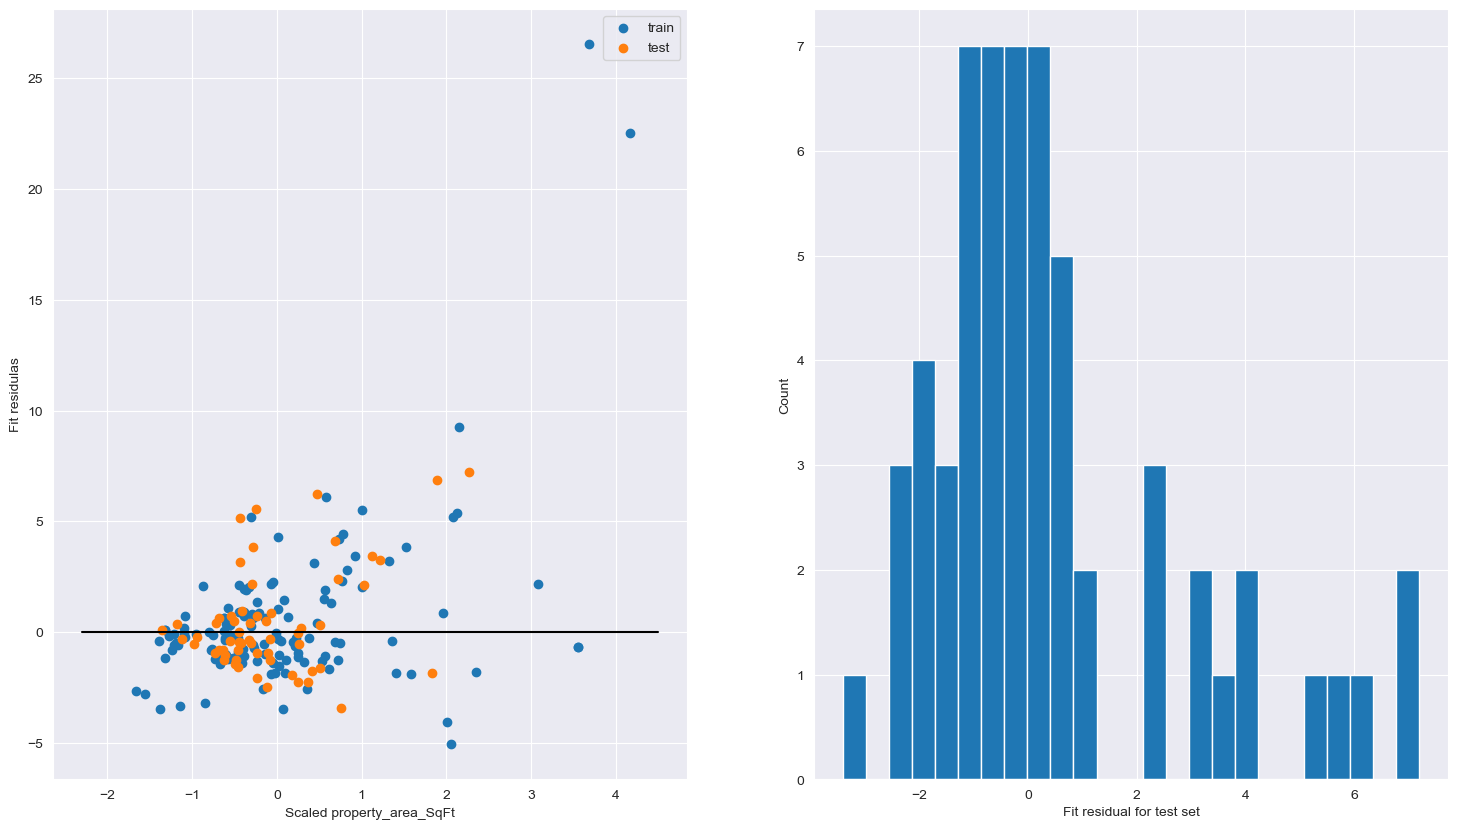

mean residuals: 0.43 
std: 2.36


In [52]:
# plot the residuals
plotResidue(knn_cv, X, y, rs=rs)

## Suport Vector Regression

In [53]:
# SVR model
svr = SVR()
pg = {
    "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
    "gamma": ['scale', 'auto'], # Kernel coefficient 
    "C": np.logspace(-3, 3, 10), # Penalty parameter
    "epsilon": np.linspace(.1, 1., 10) # the decision boundary
}
svr_cv = gridSearchReport(svr, X, y, pg, cv=10, rs=rs)

Best parameters: {'C': 1000.0, 'epsilon': 0.7000000000000001, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV score: 7.317738435952036
MSE, R2 train: 1.5991092372843756 ,  0.9594297727274271
MSE, R2 test: 5.765048812022722 ,  0.711483603596833
Elapsed time: 31.85 s , 0.53 min


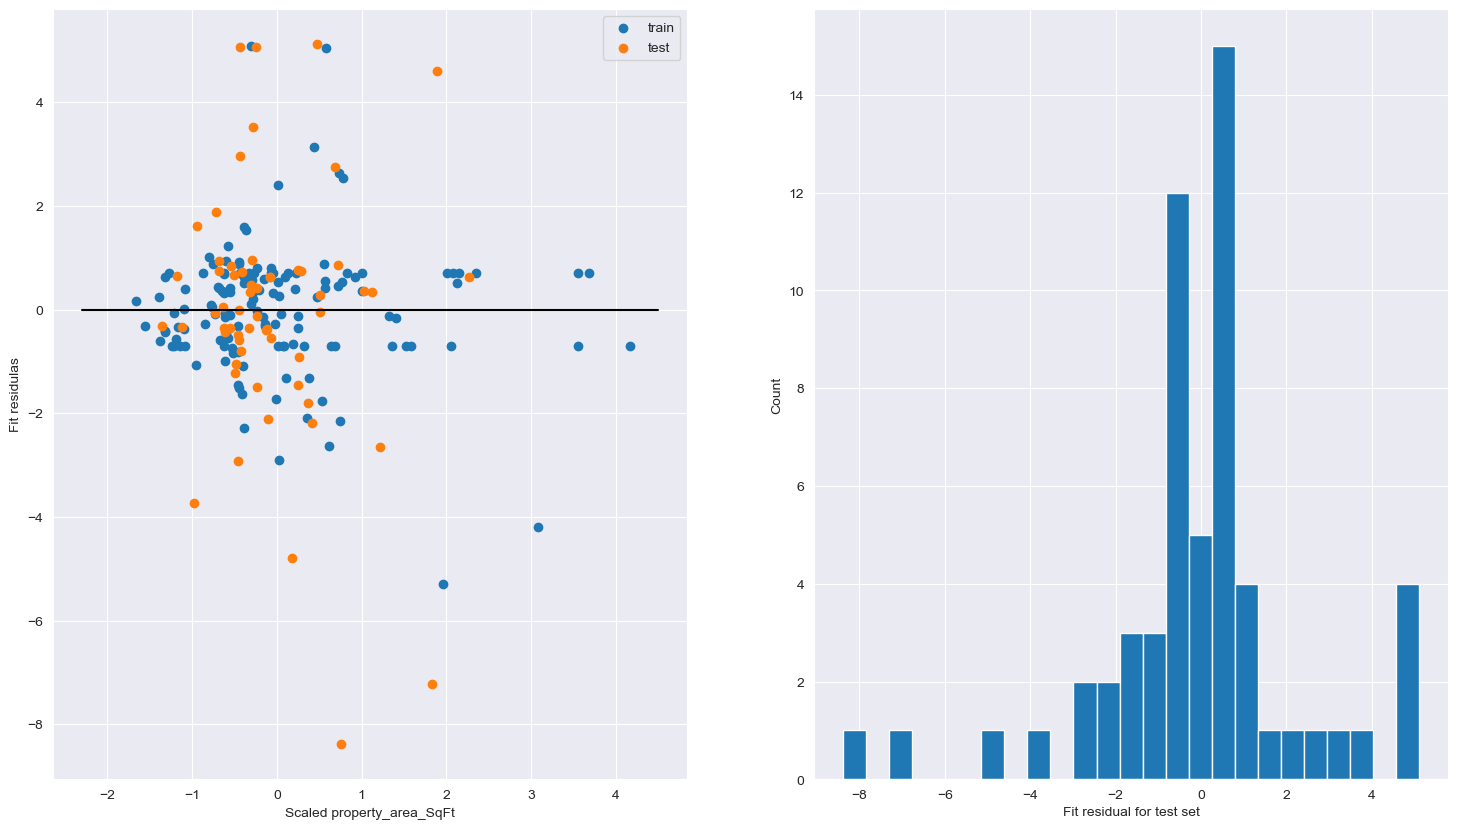

mean residuals: -0.05 
std: 2.4


In [54]:
# plot the residuals
plotResidue(svr_cv, X, y, rs=rs)

## Comparing the estimators

In [59]:
# fcuntions to make a comparision between all the models
def sortXy( X, y ):
    """
    Prepares the features to have the fit only for "surface" variable. 
    """ 
    df = X.copy()
    df["price"] = y
    df = df.sort_values("property_area_SqFt").reset_index(drop=True)
    return df.drop(columns=["price"]), df["price"]

#######################################
def get_scores( X, y, est_name, est ):
    """
    Computes the validation and tets scores. 
    Params:
        X: Pandas dataframe, feature data
        y: Pandas series, target
        est_name: str
            estromator name
        est: regressor
            the regression estimator
    Return:
        r2 for the test sample, mse for validation sample and the labels for plotting.
    """    
    y_pred = est.predict(X)
    r2_test = round(r2_score(y, y_pred), 1)
    if est_name=="Linear Regression" :
        mse_cv = "--"
    elif est_name=="Extreme Gradient Boosting":
        mse_cv = round(df_grid_best["val_score"].to_list()[0],1)
    elif est_name=="K-Nearest Neighbors Regression":
        mse_cv = round(score_val_knn,1)
    else :
        mse_cv=round(abs(est.best_score_), 1)
    
    lbl = est_name+":  R2_test="+str(r2_test)+", MSE_cv="+str(mse_cv)
    
    return r2_test, mse_cv, lbl

    
#######################################
def plotLines( X, y, estimators, rs):
    """
    Plots the fitted curve for the given estimators to test data vs. "surface" variable.
    Params:
        X: Pandas dataframe 
            features 
        y: Pandas series 
            target
        estimators: list 
            list of regressors
        rs: int 
            random state
    """    
    X, y = sortXy( X, y )
    colors = ["k", "b", "r", "g"]
    fig, axe = plt.subplots(figsize=(20,10))
    axe.scatter( X["property_area_SqFt"], y )
    i = 0
    for k, estimator  in estimators.items():
        r2_test, mse_cv, label = get_scores( X, y, k, estimator )
        axe.plot(X["property_area_SqFt"], estimator.predict(X), label=label, c=colors[i])
        i+=1
    axe.set_xlabel("Scaled property_area_SqFt")
    axe.set_ylabel("Price in millions")
    axe.legend()



In [60]:
estimators1 = {
              "Linear Regression": lr, 
              "Ridge Regression": ridg_cv, 
              "Lasso Regression": lasso_cv, 
              "Elastic Net": elastic_cv, 
}

estimators2 = {              
              "Random Forest Regression": rfr_cv, 
              "Extreme Gradient Boosting": xgbr, 
              "K-Nearest Neighbors Regression": knn_cv, 
              "Support Vector Regression": svr_cv
}

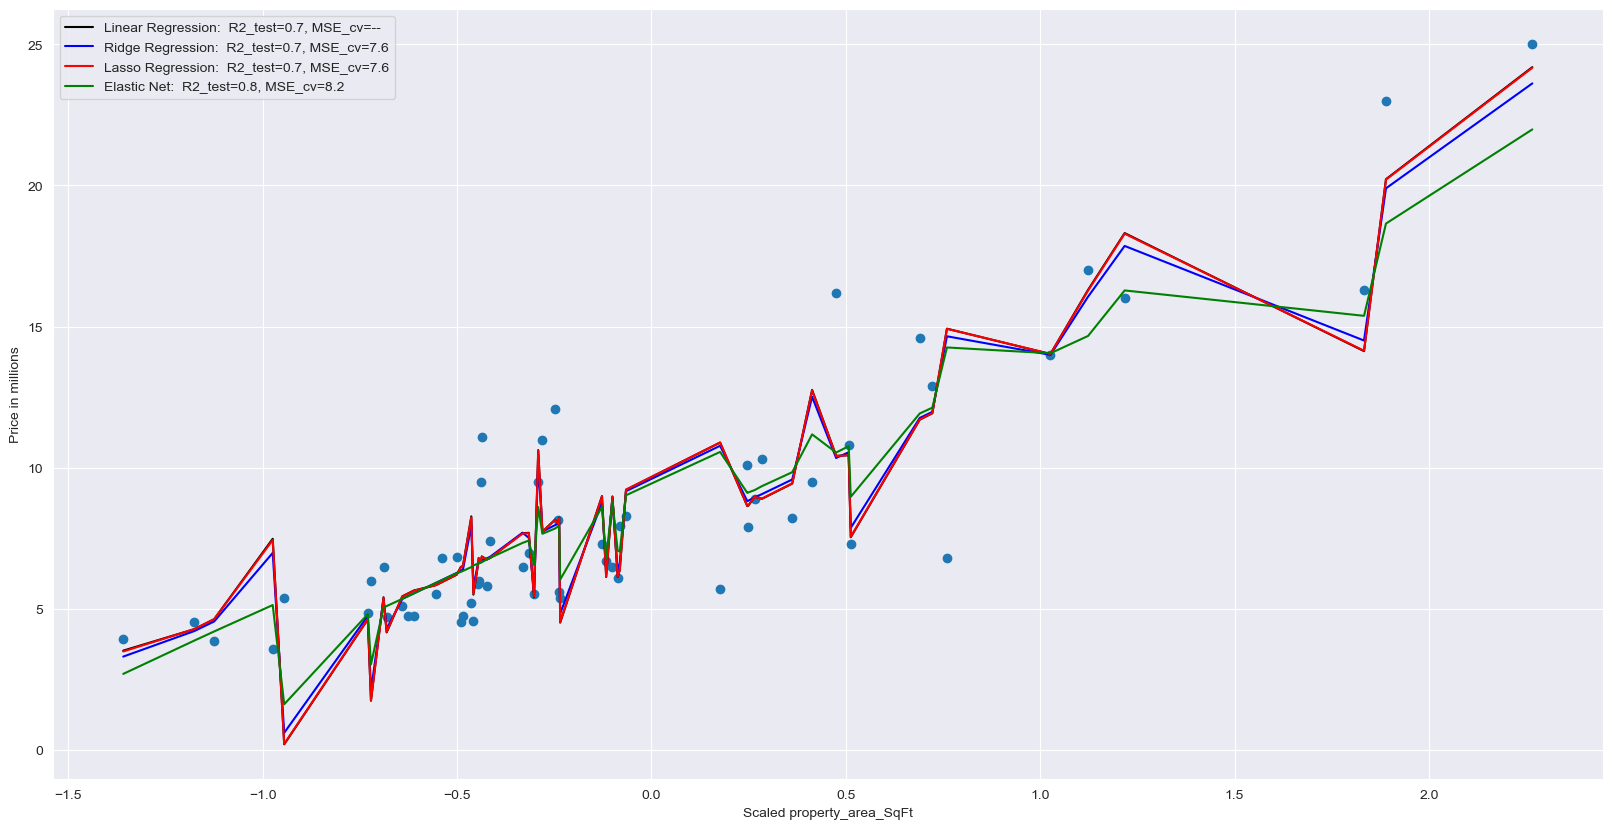

In [61]:
plotLines(X_test ,y_test, estimators1, rs=rs)

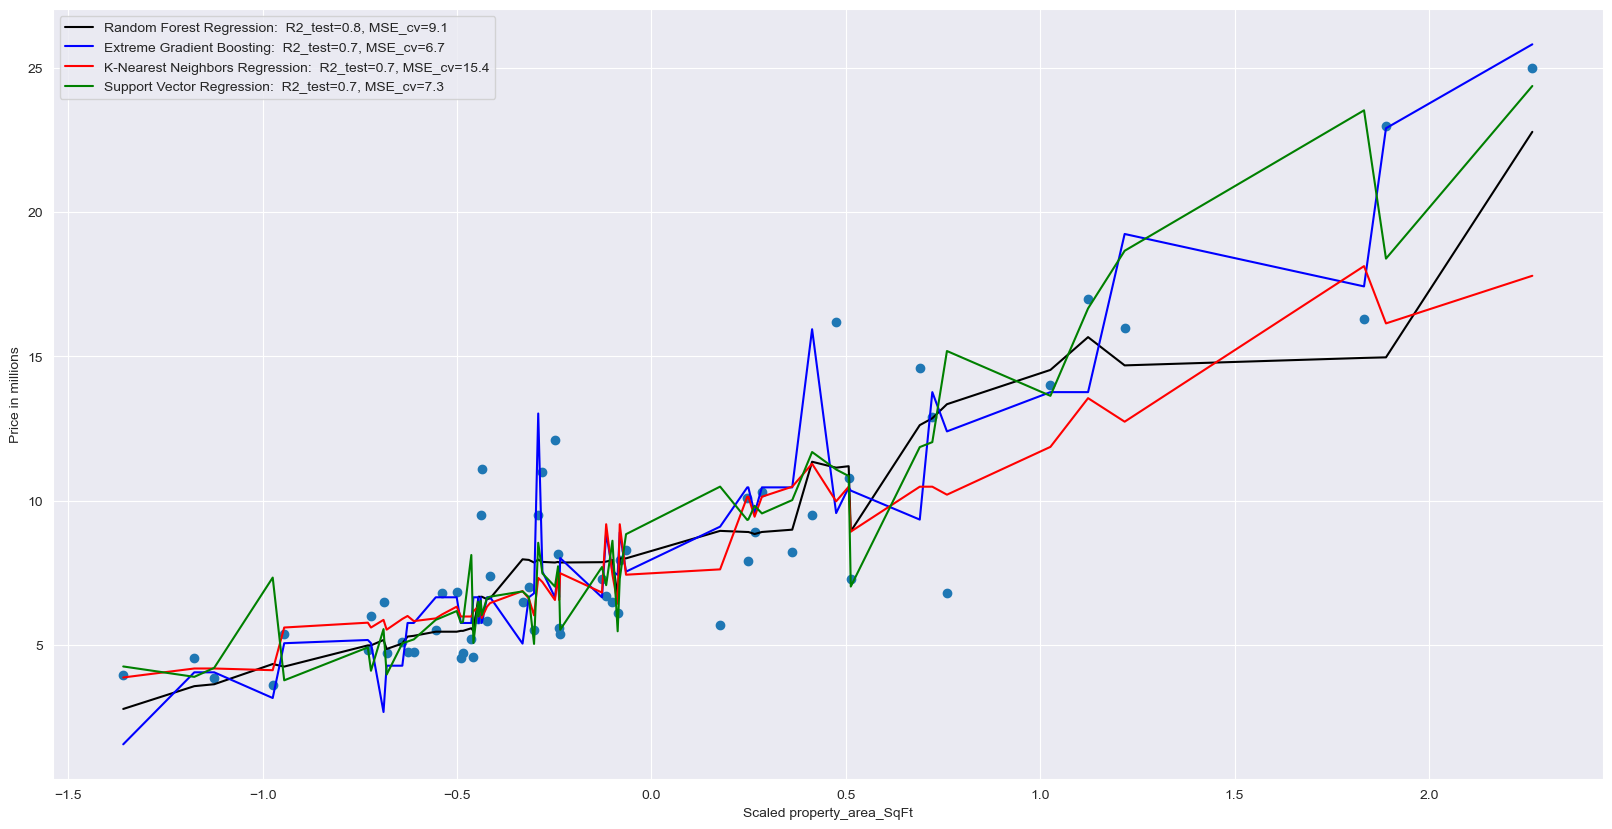

In [62]:
plotLines(X_test,y_test, estimators2, rs=rs)

## Conclusion

We have conclude that our best estimator at first is the  - 
 - Extreme Gradient boosting 
 - followd by Support Vector Regressor and then the Linear regression methods